In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
furl = "../data/GHS_BUILT_S_E2018_GLOBE_R2023A_54009_10_V1_0_R4_C20.tif"

In [3]:
import rioxarray
bus = rioxarray.open_rasterio(furl).squeeze()

In [4]:
bus

<xarray.DataArray (y: 100000, x: 100000)> Size: 10GB
[10000000000 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 800kB 9.59e+05 9.59e+05 ... 1.959e+06 1.959e+06
  * y            (y) float64 800kB 6e+06 6e+06 6e+06 6e+06 ... 5e+06 5e+06 5e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0

In [92]:
region_id = 69333

In [93]:
etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/enclosures/enclosure_{region_id}.parquet')

In [94]:
etcs['num_index'] = np.arange(1, etcs.shape[0] + 1)

In [95]:
etcs_utm = etcs.to_crs(bus.rio.crs)

In [96]:
geom = etcs_utm.reset_index()[['geometry', 'num_index']].values.tolist()

In [97]:
import shapely

In [98]:
shapely.GeometryCollection(etcs_utm.geometry.values).bounds

(1056322.2981511406, 5824057.637521706, 1175687.5972397642, 5913205.059116768)

In [99]:
minx, miny, maxx, maxy = shapely.GeometryCollection(etcs_utm.geometry.values).bounds

In [15]:
test = rioxarray.open_rasterio(
    filename=furl, 
    chunks='auto', 
    parse_coordinates=False,
    masked=True
).rio.clip_box(minx, miny, maxx, maxy)

In [16]:
from rasterio import features
fields_rasterized = features.rasterize(geom, out_shape=(test.shape[1], test.shape[2]), transform=test.rio.transform())

In [100]:
ebua = pd.Series(test.as_numpy().values.flatten()).groupby(fields_rasterized.flatten()).agg(['sum', 'describe'])

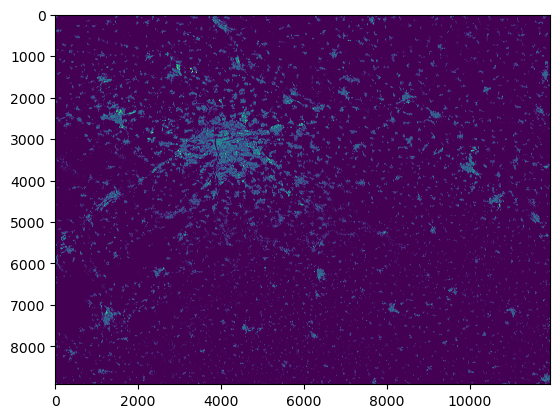

In [101]:
import matplotlib.pyplot as plt
plt.imshow(test.data[0])

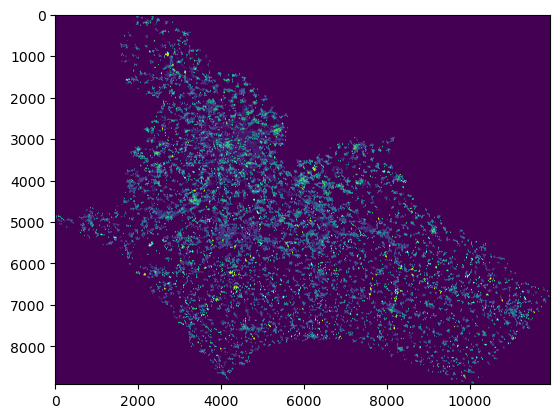

In [102]:
plt.imshow(fields_rasterized)

In [106]:
ebua.columns = ebua.columns.get_level_values(1)
ebua.columns = ['sum'] + ebua.columns[1:].tolist()

In [107]:
etcs = etcs.merge(ebua, left_on='num_index', right_index=True, how='left')

In [108]:
etcs = etcs.fillna(0)

In [109]:
etcs['ratio'] = etcs['sum'] / etcs.area
etcs['area'] = etcs.area

In [110]:
(etcs['sum'] > etcs['area']).sum()

np.int64(5)

In [111]:
cells = morphotopes_to_etcs(region_id)
buildings = morphotopes_to_etcs(region_id, etcs=False)

In [112]:
buildings['barea'] = buildings.area

In [113]:
cells = cells.merge(buildings['barea'], right_index=True, left_index=True)

In [114]:
etcs = etcs.merge(cells.groupby('enclosure_index')['barea'].sum(), left_on='eID', right_index=True)

In [115]:
etcs['nbbua'] = etcs['sum'] - etcs['barea']

In [116]:
etcs['nbbua_ratio'] = etcs['nbbua'] / etcs['area']

In [117]:
etcs['bratio'] = etcs['barea'] / etcs['sum']

In [150]:
etcs['gb_ratio'] = (etcs['area']-etcs['sum']) / etcs['barea']

In [151]:
plotting = etcs

In [152]:
import lonboard
from sidecar import Sidecar

In [153]:
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pandas/core/dtypes/cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [154]:
sc = Sidecar(title='tess')
m = lonboard.Map(layer)
with sc:
    display(m)

In [155]:
etcs.columns

Index(['eID', 'geometry', 'num_index', 'sum', 'count', 'mean', 'std', 'min',
       '25%', '50%', '75%', 'max', 'ratio', 'area', 'barea', 'nbbua',
       'nbbua_ratio', 'bratio', 'gb_ratio'],
      dtype='object')

In [164]:
column = '75%'

In [165]:
from lonboard.colormap import apply_continuous_cmap
import matplotlib as mpl
from mapclassify import classify

classifier = classify(plotting[column], 'quantiles', k=100)
normalizer = mpl.colors.Normalize(0, classifier.bins.shape[0])
vals = normalizer(classifier.yb)
layer.get_fill_color = apply_continuous_cmap(vals, mpl.colormaps['viridis'])

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 100 classes. Setting k to 81.
  self.bins = quantile(y, k=k)


In [68]:
res = etcs.dissolve('morph', aggfunc=['mean', 'sum'])

In [76]:
res.columns

Index([                 'geometry', ('enclosure_index', 'mean'),
        ('enclosure_index', 'sum'),           ('label', 'mean'),
                  ('label', 'sum'),       ('num_index', 'mean'),
              ('num_index', 'sum'),            ('mean', 'mean'),
                   ('mean', 'sum'),          ('median', 'mean'),
                 ('median', 'sum'),             ('sum', 'mean'),
                    ('sum', 'sum'),           ('ratio', 'mean'),
                  ('ratio', 'sum'),            ('area', 'mean'),
                   ('area', 'sum')],
      dtype='object')

In [79]:
res = res[~(res.index.str.split('_').str[-1] == '-1')]

In [91]:
res.columns = res.columns.str.join('_')
res.columns = ['geometry'] + list(res.columns[1:]) 

In [106]:
res['morph_ratio'] = res['sum_sum'] / res.area

In [110]:
# res.reset_index().explore(prefer_canvas=True, tiles='cartodb.Positron', column=res['morph_ratio'].values)

In [122]:
# spatial lag the values ...
# try sum of construction minus building area  ...
# ratio of construction to building